In [1]:
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for each class.

    PARAMETERS
    ----------
    model       A callable model that can take 3-d input (bias + x1, x2) and produce
                a class label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be calculated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Add a bias term of 1 to each point in the grid, resulting in shape [N, 3]
    bias_column = np.ones((data.shape[0], 1))  # Create a column of ones for the bias term
    data_with_bias = np.hstack([bias_column, data])  # Combine bias, x1, and x2 columns

    # Predict the class of each point in the grid using the model
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data_with_bias).to(dtype=torch.float32))
            predicted_labels = torch.argmax(pl, dim=1).numpy()  # Get class predictions
    else:
        predicted_labels = model(data_with_bias)

    # Reshape the predictions to match the grid shape for plotting
    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()
def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

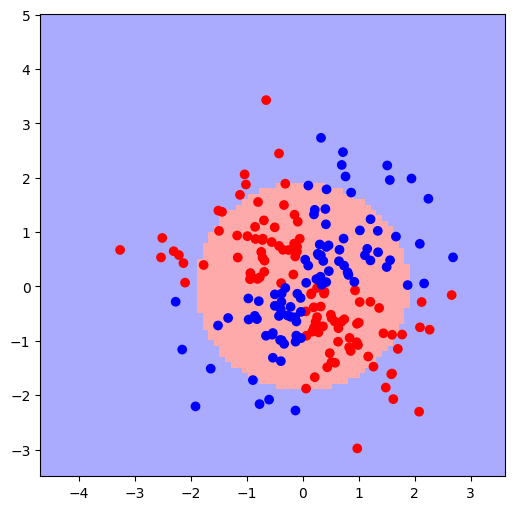

In [2]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
#        self.l1 = nn.Linear(input_size,nodes)
#        self.activation = nn.Tanh()

    def forward(self,x):
#        output = self.l1(x)
#        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap



In [4]:
## function for plot learning curves

def plot_learning_curves(train_loss, val_loss, title="Learning Curves"):
    """
    Plot the learning curves for training and validation loss.

    Parameters:
    - train_loss: List of training loss values over epochs.
    - val_loss: List of validation loss values over epochs.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_best_decision_surface(model, x_test, y_test, title="Decision Surface", axis_limits = (-5,5,-5,5)):
    """
    Plot the decision surface of the best model using test data.

    Parameters:
    - model: Trained model to generate predictions.
    - x_test: Test dataset features (2D array).
    - y_test: Test dataset labels.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model, axis_limits = axis_limits)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()




 Pytorch Implementation with MCE: 
hyperparameters: 
 epochs: 30 
 learning_rate: 0.01 
 batch size: 16


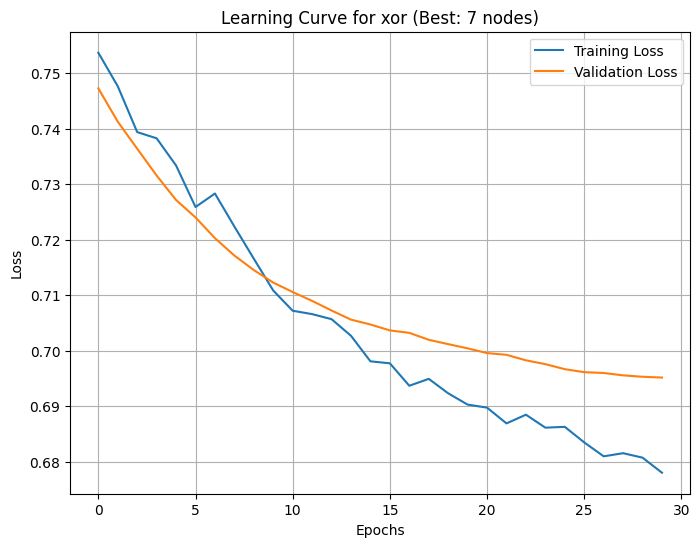

final text accuracy for xor: 0.605


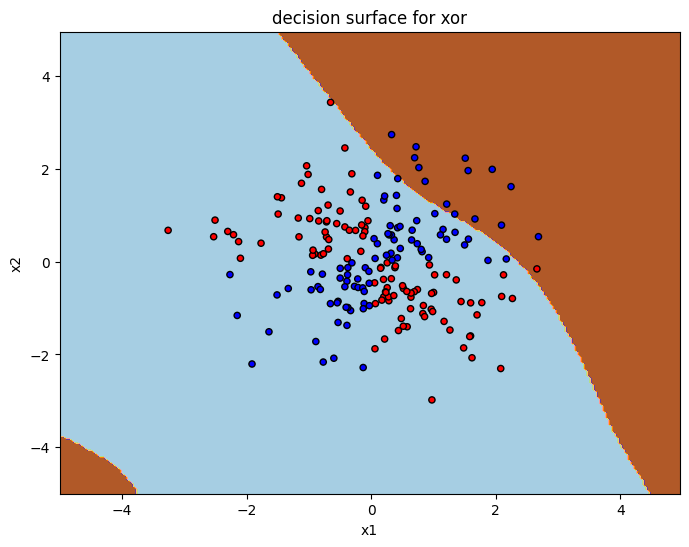

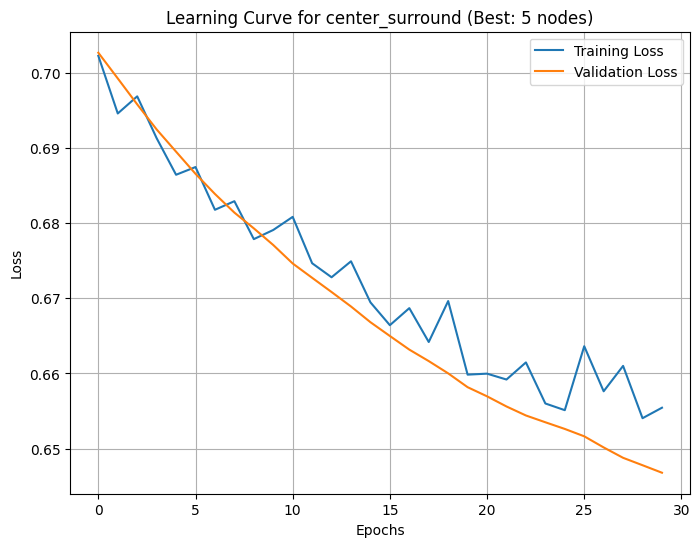

final text accuracy for center_surround: 0.615


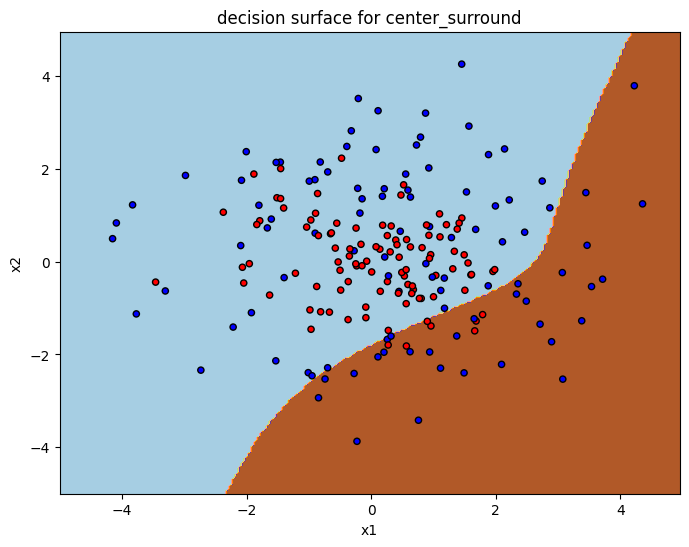

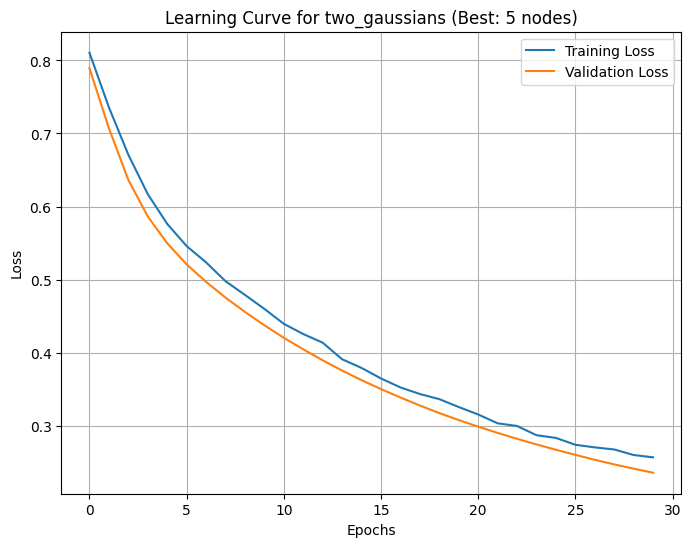

final text accuracy for two_gaussians: 0.925


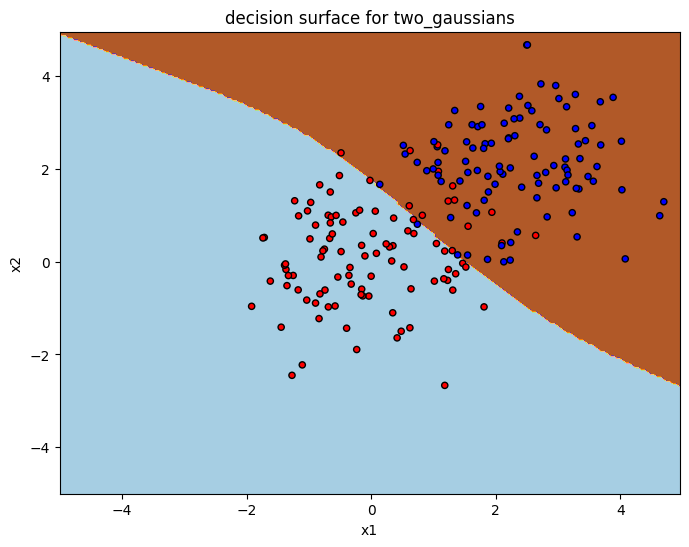

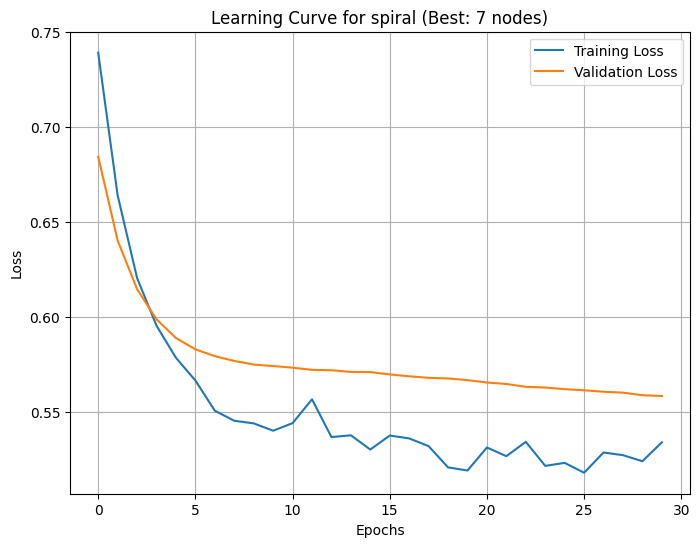

final text accuracy for spiral: 0.8


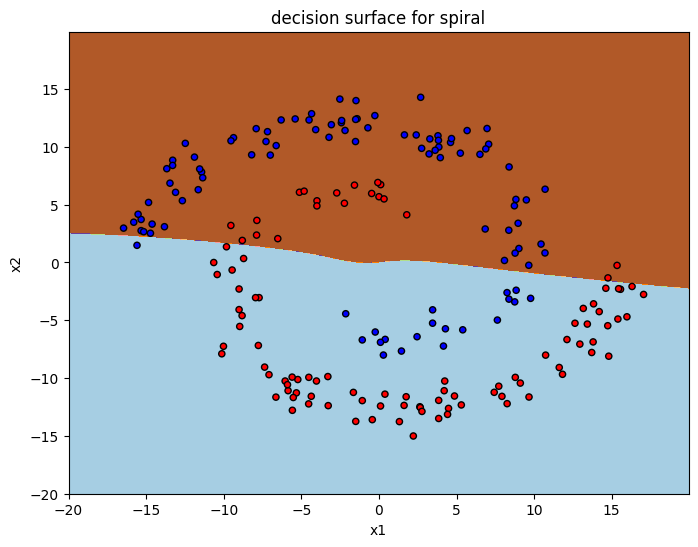

I choose epoch 30, with a batch size of 16, and learning rate be 0.01. Since there are only serveral hundreds of data in the traininig dataset, 16 * 30 = 480 would fit the condition and those two number are close so that it would optimize the performance.


In [5]:

# FFNN Class Definition
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=False)
        #use Sigmoid as activation function
        self.activation_fn = activation
    
    def forward(self, x):
        #apply activation function after doing linear combination between input layer and hidden layer.
        x = self.activation_fn(self.fc1(x))
        # since we are using Cross entropy loss as the loss function， we dont need activation function for output layer
        x = self.fc2(x)
        return x

# Training and Evaluation Helper Functions

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    """
    params:
        model: A model instance (FFNN in our case)
        train_loader: A DataLoader type for training data for each iteration
        val_loader: A DataLoader type for validation data, which is used for each iteration.
        criterion: The loss function used (e.g: Muti-class Cross Entropy loss function)
        optimizer: 
        epochs: the number of training and validation iteration.
    """
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        model.train() # set model to train mode
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            #clear the gradient stored in the optimizer.
            y_batch = y_batch.squeeze().long()
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            #use gradient descent to train mode by using backward(), calculating the gradient, and step(), do the gradient descent process.
            loss.backward()
            optimizer.step()
            #calculate the average loss of this epoch and store it in train_loss list
            epoch_loss += loss.item()
        train_loss.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_epoch_loss = 0
        for x_val, y_val in val_loader:
            y_val = y_val.squeeze().long()
            val_output = model(x_val)
            val_loss_batch = criterion(val_output, y_val)
            val_epoch_loss += val_loss_batch.item()
        val_loss.append(val_epoch_loss / len(val_loader))
    return train_loss, val_loss

def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            y_batch = y_batch.squeeze().long()
            output = model(x_batch)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total
def load_data(name):
        x_train, y_train, _ = read_data(name, 'train')
        x_test, y_test, _ = read_data(name, 'test')
        x_val, y_val, _ = read_data(name, 'valid')
        
        x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
        x_val, y_val = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
        x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)
        
        # Loaders for batching
        train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_train, y_train), batch_size=16, shuffle=True)
        val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_val, y_val), batch_size=16, shuffle=False)
        test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_test, y_test), batch_size=16, shuffle=False)
        
        return train_loader, val_loader, test_loader
    

# Hyperparameters and configurations
print(" Pytorch Implementation with MCE: ")
nodes_options = [2, 3, 5, 7, 9]
epochs = 30
learning_rate = 0.01
dataset_names = ["xor", "center_surround", "two_gaussians", "spiral"]
print(f"hyperparameters: \n epochs: {epochs} \n learning_rate: {learning_rate} \n batch size: 16")
for name in dataset_names:
    train_loader, val_loader, test_loader = load_data(name)
    best_accuracy = 0
    best_model = None
    best_k = 0
    best_train_loss, best_val_loss = None, None
    for node in nodes_options:
        # two weights and 1 bias
        ffnn = FFNN(3, node, 2, nn.Tanh())
        criterion = nn.CrossEntropyLoss()
        # use Stochastic Gradient Descent as my optimizer
        optimizer = optim.SGD(ffnn.parameters(), lr = learning_rate)
        # get the list of train loss, validation loss for each epoch
        train_loss, val_loss = train_model(ffnn, train_loader, val_loader, criterion, optimizer, epochs)
        # get accuracy of model
        accuracy = evaluate_model(ffnn, test_loader)
        #find best accuracy and other variables
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = ffnn
            best_k = node
            best_train_loss, best_val_loss = train_loss, val_loss
    
    plot_learning_curves(best_train_loss, best_val_loss, f"Learning Curve for {name} (Best: {best_k} nodes)")
    print(f"final text accuracy for {name}: {best_accuracy}")
    x_test, y_test, _ = read_data(name, 'test')
    y_test = y_test.squeeze()
    x_test = x_test = x_test[:, 1:]
    if name == "spiral":
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}", axis_limits=(-20, 20, -20, 20))
    else:
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}")
print("I choose epoch 30, with a batch size of 16, and learning rate be 0.01. Since there are only serveral hundreds of data in the traininig dataset, 16 * 30 = 480 would fit the condition and those two number are close so that it would optimize the performance.")
    





 Pytorch Implementation with MSE: 
hyperparameters: 
 epochs: 30 
 learning_rate: 0.01 
 batch size: 16


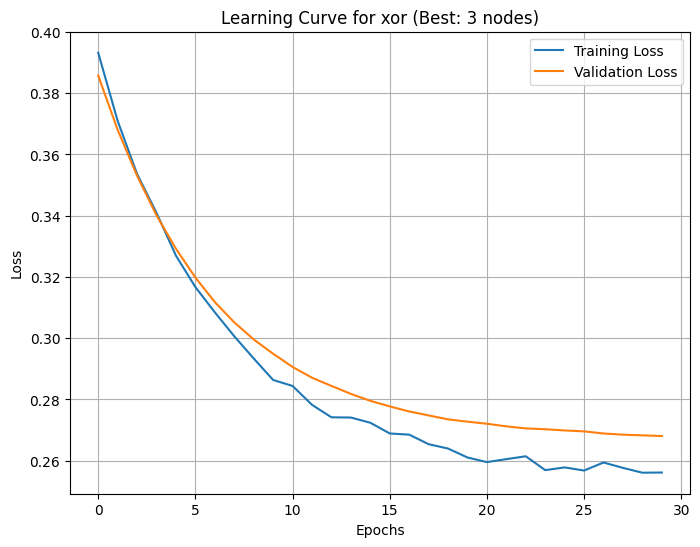

final text accuracy for xor: 0.615


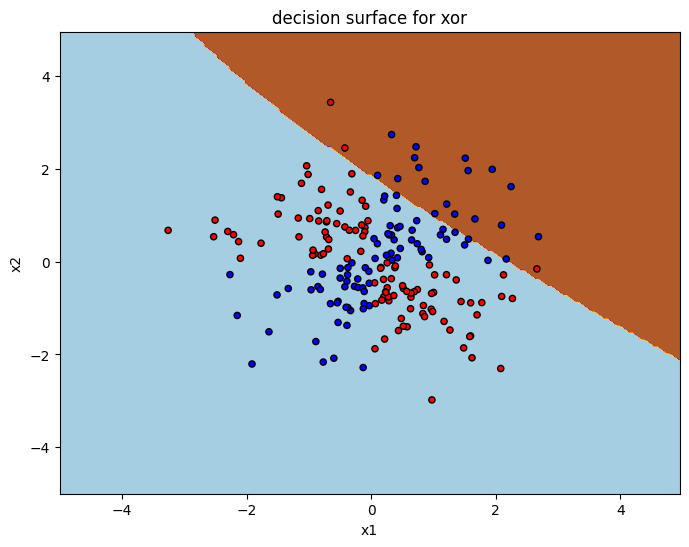

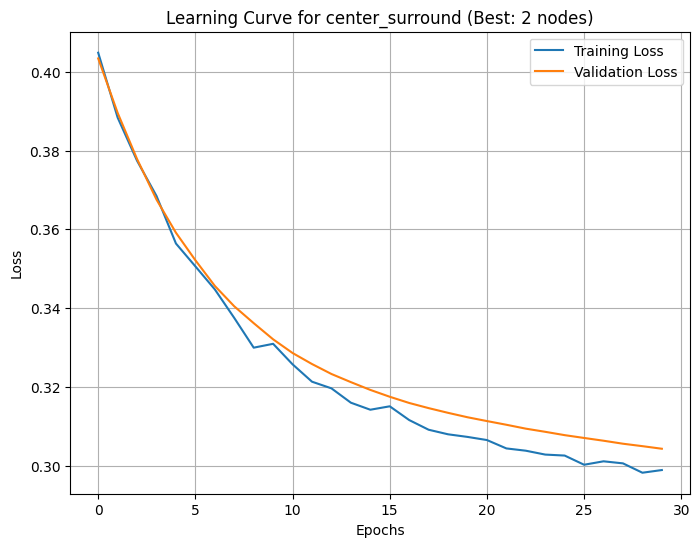

final text accuracy for center_surround: 0.555


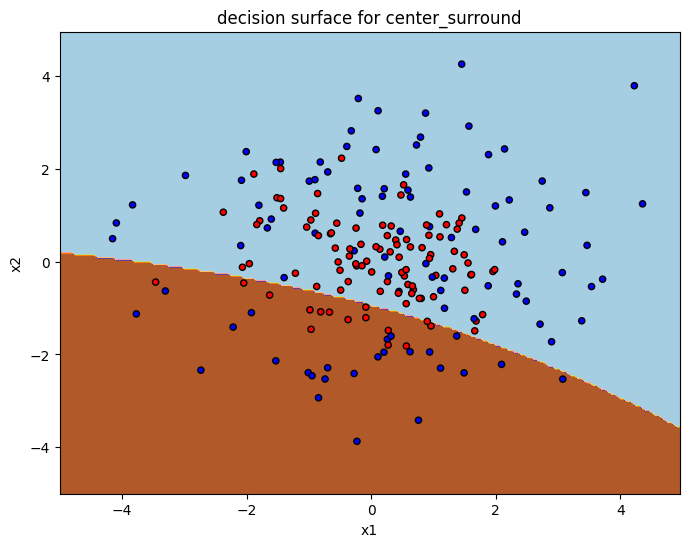

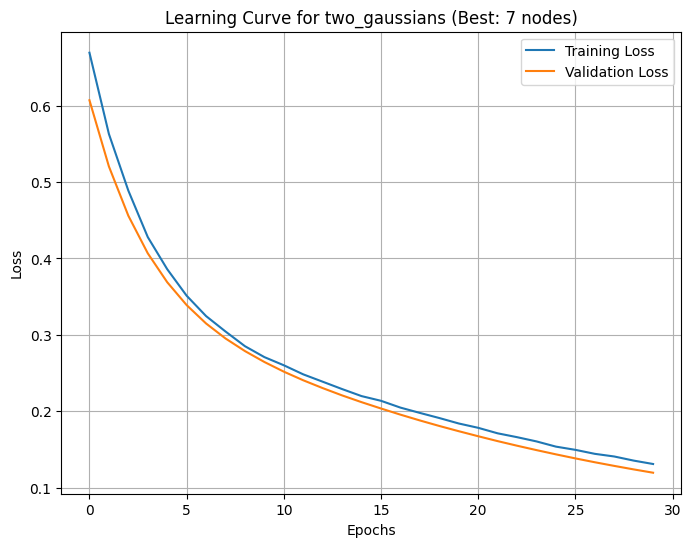

final text accuracy for two_gaussians: 0.915


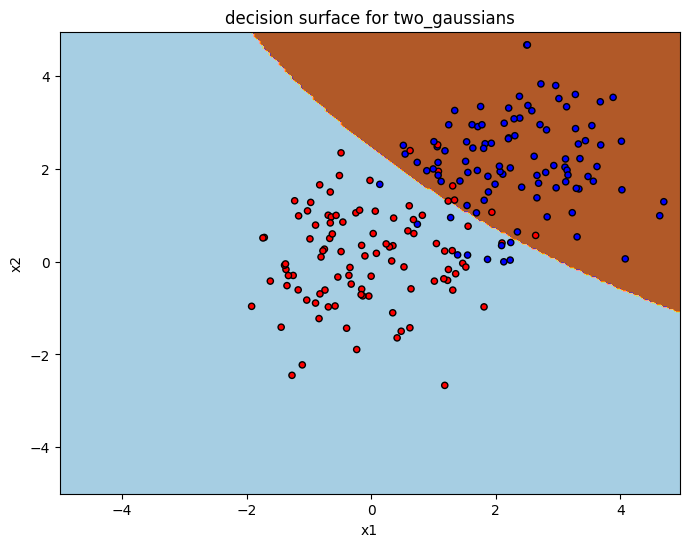

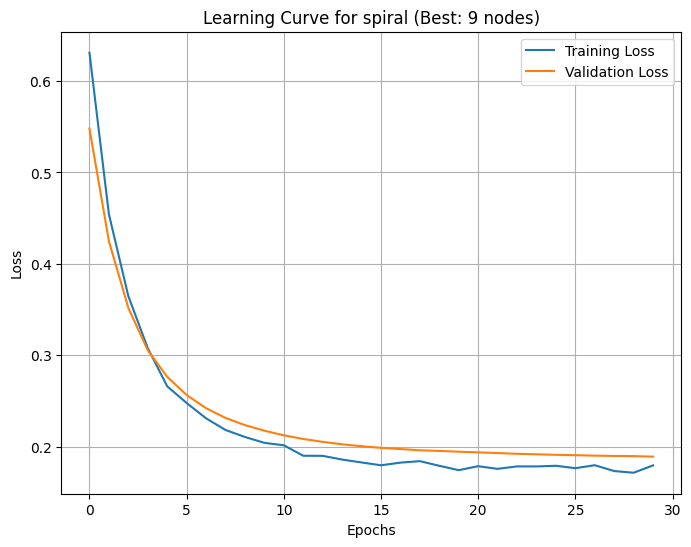

final text accuracy for spiral: 0.805


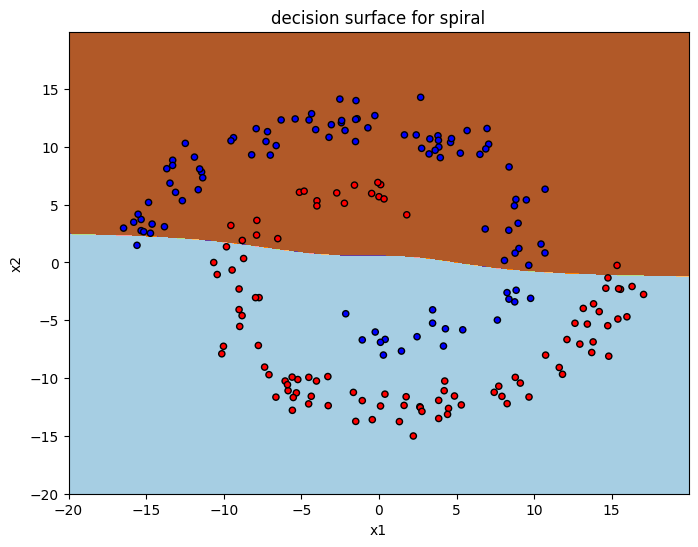

I choose epoch 30, with a batch size of 16, and learning rate be 0.01. Since there are only serveral hundreds of data in the traininig dataset, 16 * 30 = 480 would fit the condition and those two number are close so that it would optimize the performance.


In [6]:
import torch.nn.functional as F
print(" Pytorch Implementation with MSE: ")
def train_model_MSE(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        model.train()  # set model to train mode
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            # Convert y_batch to one-hot encoding for MSE
            y_batch = F.one_hot(y_batch.squeeze().long(), num_classes=2).float()
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_val = F.one_hot(y_val.squeeze().long(), num_classes=2).float()
                val_output = model(x_val)
                val_loss_batch = criterion(val_output, y_val)
                val_epoch_loss += val_loss_batch.item()
        val_loss.append(val_epoch_loss / len(val_loader))
    return train_loss, val_loss

def evaluate_model_MSE(model, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y_batch.squeeze()).sum().item()
            total += y_batch.size(0)
    return correct / total

nodes_options = [2, 3, 5, 7, 9]
epochs = 30
learning_rate = 0.01
dataset_names = ["xor", "center_surround", "two_gaussians", "spiral"]
print(f"hyperparameters: \n epochs: {epochs} \n learning_rate: {learning_rate} \n batch size: 16")
for name in dataset_names:
    train_loader, val_loader, test_loader = load_data(name)
    best_accuracy = 0
    best_model = None
    best_k = 0
    best_train_loss, best_val_loss = None, None
    for node in nodes_options:
        # two weights and 1 bias, and use Sigmoid() to train
        ffnn = FFNN(3, node, 2, nn.Sigmoid())
        criterion = nn.MSELoss()
        # use Stochastic Gradient Descent as my optimizer
        optimizer = optim.SGD(ffnn.parameters(), lr = learning_rate)
        # get the list of train loss, validation loss for each epoch
        train_loss, val_loss = train_model_MSE(ffnn, train_loader, val_loader, criterion, optimizer, epochs)
        # get accuracy of model
        accuracy = evaluate_model_MSE(ffnn, test_loader)
        #find best accuracy and other variables
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = ffnn
            best_k = node
            best_train_loss, best_val_loss = train_loss, val_loss
    
    plot_learning_curves(best_train_loss, best_val_loss, f"Learning Curve for {name} (Best: {best_k} nodes)")
    print(f"final text accuracy for {name}: {best_accuracy}")
    x_test, y_test, _ = read_data(name, 'test')
    y_test = y_test.squeeze()
    x_test = x_test = x_test[:, 1:]
    if name == "spiral":
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}", axis_limits=(-20, 20, -20, 20))
    else:
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}")
print("I choose epoch 30, with a batch size of 16, and learning rate be 0.01. Since there are only serveral hundreds of data in the traininig dataset, 16 * 30 = 480 would fit the condition and those two number are close so that it would optimize the performance.")


## manual gradient and update

Manual Implementation with Cross-Entropy Loss:

Training on xor dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.5950
  Training with 3 hidden nodes...
    Accuracy: 0.6100
  Training with 5 hidden nodes...
    Accuracy: 0.6100
  Training with 7 hidden nodes...
    Accuracy: 0.6050
  Training with 9 hidden nodes...
    Accuracy: 0.6000


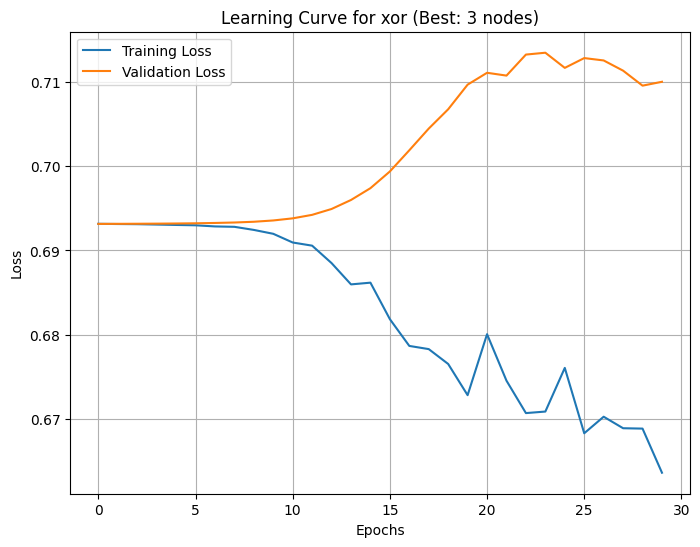

Final test accuracy for xor: 0.61
data_with_bias shape: (40000, 3)
Forward output shape: (40000, 2)
Predicted labels shape after argmax: (40000,)


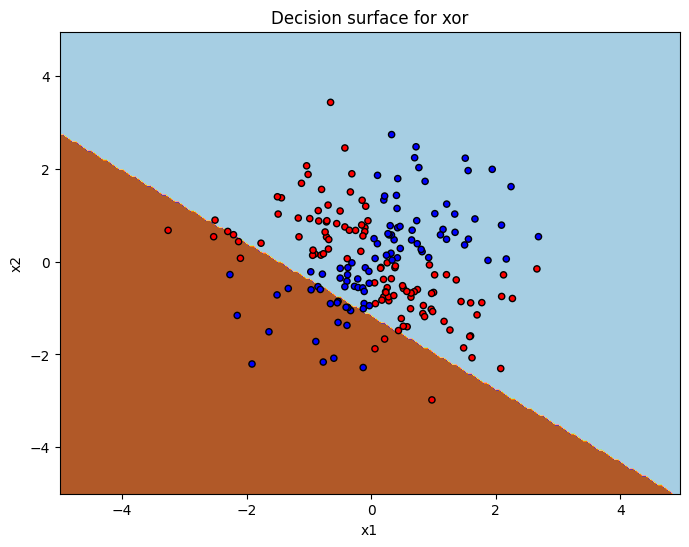


Training on center_surround dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.5650
  Training with 3 hidden nodes...
    Accuracy: 0.5600
  Training with 5 hidden nodes...
    Accuracy: 0.5500
  Training with 7 hidden nodes...
    Accuracy: 0.5550
  Training with 9 hidden nodes...
    Accuracy: 0.5450


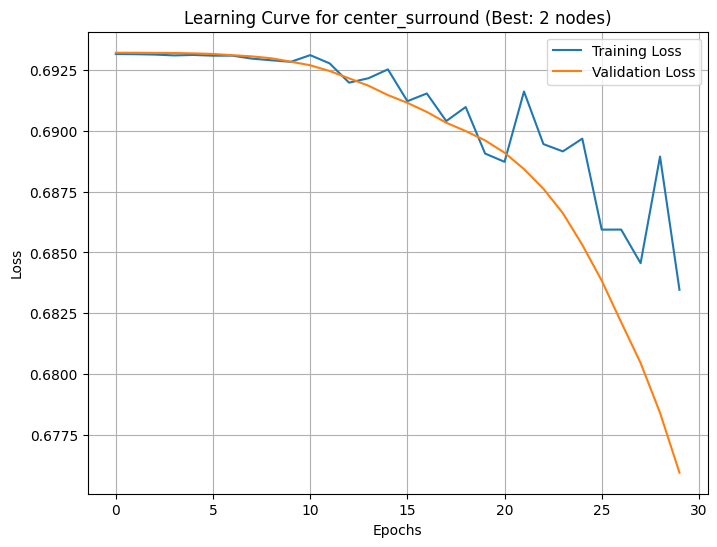

Final test accuracy for center_surround: 0.565
data_with_bias shape: (40000, 3)
Forward output shape: (40000, 2)
Predicted labels shape after argmax: (40000,)


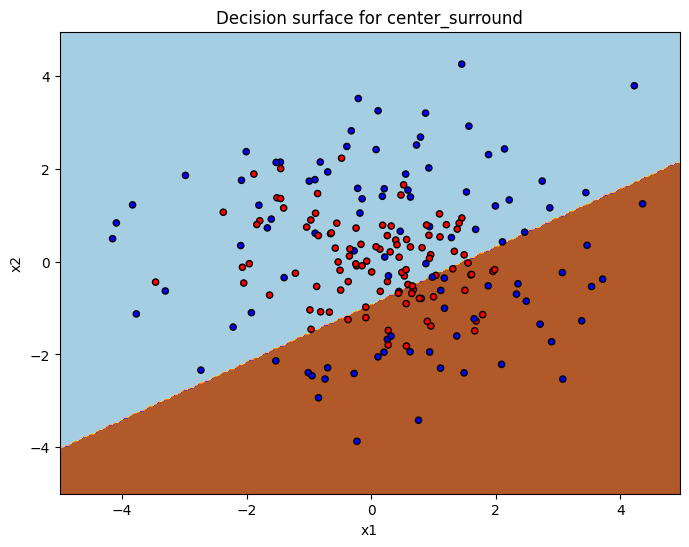


Training on two_gaussians dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.9150
  Training with 3 hidden nodes...
    Accuracy: 0.9150
  Training with 5 hidden nodes...
    Accuracy: 0.9150
  Training with 7 hidden nodes...
    Accuracy: 0.9150
  Training with 9 hidden nodes...
    Accuracy: 0.9150


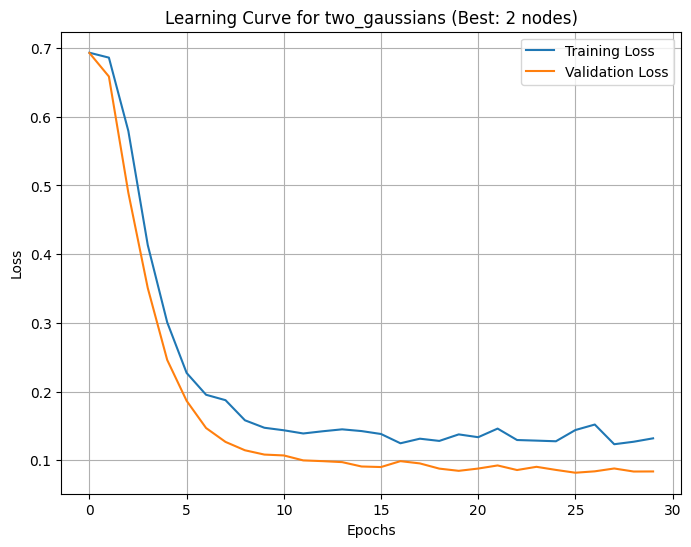

Final test accuracy for two_gaussians: 0.915
data_with_bias shape: (40000, 3)
Forward output shape: (40000, 2)
Predicted labels shape after argmax: (40000,)


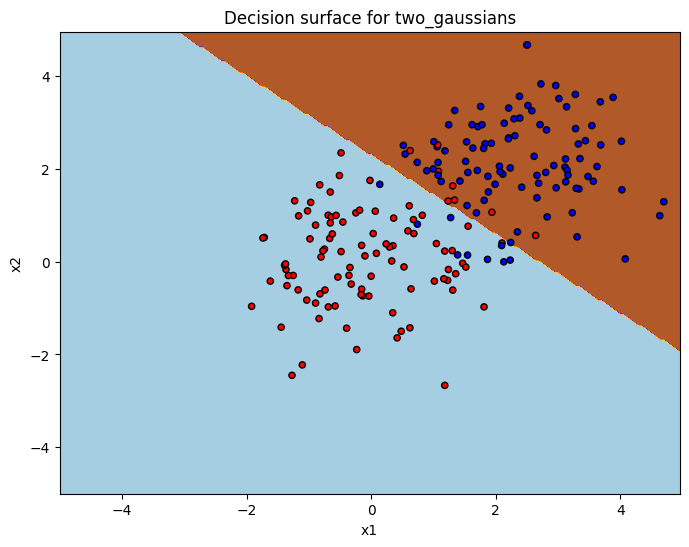


Training on spiral dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.7800
  Training with 3 hidden nodes...
    Accuracy: 0.7200
  Training with 5 hidden nodes...
    Accuracy: 0.7600
  Training with 7 hidden nodes...
    Accuracy: 0.7550
  Training with 9 hidden nodes...
    Accuracy: 0.7500


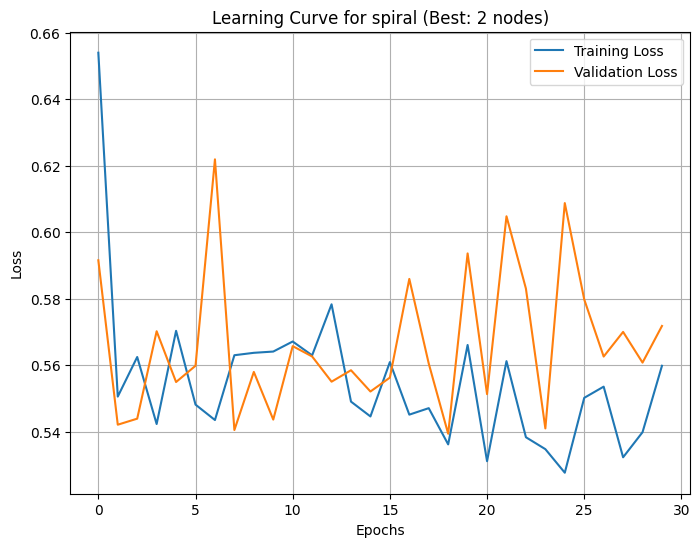

Final test accuracy for spiral: 0.78
data_with_bias shape: (640000, 3)
Forward output shape: (640000, 2)
Predicted labels shape after argmax: (640000,)


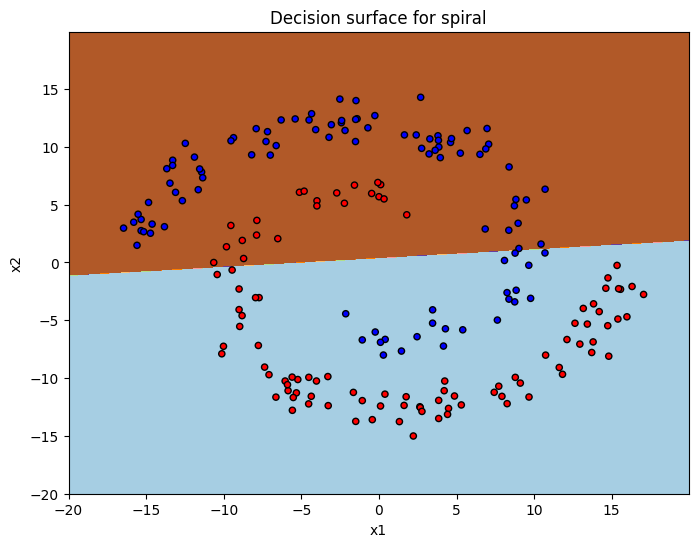

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class ManualFFNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights with random values
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        
        # Store dimensions
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Store intermediate values for backpropagation
        self.x = None
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None

    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x)**2
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, x):
        # Store input
        self.x = x
        
        # First layer
        self.z1 = np.dot(x, self.W1)
        self.a1 = self.tanh(self.z1)
        
        # Second layer
        self.z2 = np.dot(self.a1, self.W2)
        self.a2 = self.softmax(self.z2)
        
        return self.a2
    
    def backward(self, y):
        batch_size = self.x.shape[0]
        
        # Convert y to one-hot encoding if it's not already
        if len(y.shape) == 1:
            y_one_hot = np.zeros((batch_size, self.output_dim))
            y_one_hot[np.arange(batch_size), y.astype(int)] = 1
        else:
            y_one_hot = y
        
        # Gradient calculations
        dz2 = self.a2 - y_one_hot
        dW2 = np.dot(self.a1.T, dz2)
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.tanh_derivative(self.z1)
        dW1 = np.dot(self.x.T, dz1)
        
        return dW1, dW2
    
    def cross_entropy_loss(self, y_pred, y_true):
        batch_size = y_pred.shape[0]
        if len(y_true.shape) == 1:
            y_true = y_true.astype(int)
            y_true_one_hot = np.zeros((batch_size, self.output_dim))
            y_true_one_hot[np.arange(batch_size), y_true] = 1
        else:
            y_true_one_hot = y_true
            
        return -np.sum(y_true_one_hot * np.log(y_pred + 1e-8)) / batch_size


def plot_decision_surface_manual(model=None,
                                 axis_limits=(-5, 5, -5, 5),
                                 ax: matplotlib.axes.Axes = None):
    # Create a grid of points
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Add bias column
    bias_column = np.ones((data.shape[0], 1))
    data_with_bias = np.hstack([bias_column, data])
    # print(f"data_with_bias shape: {data_with_bias.shape}")  # Debugging

    # Predict the class of each point
    predicted_labels = model.forward(data_with_bias)
    # print(f"Forward output shape: {predicted_labels.shape}")  # Debugging

    # Take argmax to get class indices
    predicted_labels = np.argmax(predicted_labels, axis=1)
    # print(f"Predicted labels shape after argmax: {predicted_labels.shape}")  # Debugging

    # Reshape to match the grid shape
    assert predicted_labels.size == xx.size, (
        f"Mismatch: predicted_labels size ({predicted_labels.size}) does not match grid size ({xx.size})."
    )
    predicted_labels = predicted_labels.reshape(xx.shape)

    # Plot the result
    if ax is None:
        ax = plt
    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')
    if ax is None:
        plt.show()

def plot_best_decision_surface_manual(model, x_test, y_test, title="Decision Surface", axis_limits = (-5,5,-5,5)):
    """
    Plot the decision surface of the best model using test data.

    Parameters:
    - model: Trained model to generate predictions.
    - x_test: Test dataset features (2D array).
    - y_test: Test dataset labels.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plot_decision_surface_manual(model=model, axis_limits = axis_limits)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

def train_manual_model(model, x_train, y_train, x_val, y_val, learning_rate, epochs, batch_size):
    train_loss = []
    val_loss = []
    n_samples = x_train.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    for epoch in range(epochs):
        epoch_loss = 0
        indices = np.random.permutation(n_samples)
        x_train = x_train[indices]
        y_train = y_train[indices]
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)
            
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            y_pred = model.forward(x_batch)
            batch_loss = model.cross_entropy_loss(y_pred, y_batch)
            epoch_loss += batch_loss
            
            dW1, dW2 = model.backward(y_batch)
            
            model.W1 -= learning_rate * dW1
            model.W2 -= learning_rate * dW2
        
        val_pred = model.forward(x_val)
        val_epoch_loss = model.cross_entropy_loss(val_pred, y_val)
        
        train_loss.append(epoch_loss / n_batches)
        val_loss.append(val_epoch_loss)
    
    return train_loss, val_loss

def evaluate_manual_model(model, x_test, y_test):
    predictions = model.forward(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = y_test.astype(int)
    return np.mean(predicted_classes == true_classes)

def load_manual_data(name):
    x_train, y_train, _ = read_data(name, 'train')
    x_test, y_test, _ = read_data(name, 'test')
    x_val, y_val, _ = read_data(name, 'valid')
    
    x_train = np.array(x_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32).reshape(-1)
    x_val = np.array(x_val, dtype=np.float32)
    y_val = np.array(y_val, dtype=np.float32).reshape(-1)
    x_test = np.array(x_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32).reshape(-1)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Main training loop
print("Manual Implementation with Cross-Entropy Loss:")
nodes_options = [2, 3, 5, 7, 9]
epochs = 30
learning_rate = 0.01
batch_size = 16
dataset_names = ["xor", "center_surround", "two_gaussians", "spiral"]

for name in dataset_names:
    print(f"\nTraining on {name} dataset:")
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_manual_data(name)
    best_accuracy = 0
    best_model = None
    best_k = 0
    best_train_loss, best_val_loss = None, None
    
    for node in nodes_options:
        print(f"  Training with {node} hidden nodes...")
        model = ManualFFNN(input_dim=3, hidden_dim=node, output_dim=2)
        train_loss, val_loss = train_manual_model(
            model, x_train, y_train, 
            x_val, y_val, 
            learning_rate, epochs, batch_size
        )
        accuracy = evaluate_manual_model(model, x_test, y_test)
        print(f"    Accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_k = node
            best_train_loss, best_val_loss = train_loss, val_loss
    
    plot_learning_curves(best_train_loss, best_val_loss, 
                        f"Learning Curve for {name} (Best: {best_k} nodes)")
    print(f"Final test accuracy for {name}: {best_accuracy}")
    
    x_test_plot = x_test[:, 1:]  # Remove bias term for plotting
    if name == "spiral":
        plot_best_decision_surface_manual(best_model, x_test_plot, y_test, 
                                 title=f"Decision surface for {name}", 
                                 axis_limits=(-20, 20, -20, 20))
    else:
        plot_best_decision_surface_manual(best_model, x_test_plot, y_test, 
                                 title=f"Decision surface for {name}")